## Trading Momentum
參考[How to Build Your First Momentum Trading Strategy in Python](https://raposa.trade/blog/how-to-build-your-first-momentum-trading-strategy-in-python/?fbclid=IwAR0YqZ6jV76dYdrSF1NfLIFjANbCx5V1oyMQBQb1G8cyBrbkXCxbQaUBhnc)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def TSMStrategy(returns, period=10, shorts=False):
    if shorts:
        position = returns.rolling(period).mean().map(
            lambda x: -1 if x <= 0 else 1)
    else:
        position = returns.rolling(period).mean().map(
            lambda x: 0 if x <= 0 else 1)
    performance = position.shift(1) * returns
    return performance

In [3]:
ticker = 'SPY'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2000-01-01', end='2020-12-31')

In [4]:
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()

In [5]:
performance = TSMStrategy(returns, period=1, shorts=False).dropna()
years = (performance.index.max() - performance.index.min()).days / 365
perf_cum = np.exp(performance.cumsum())
tot = perf_cum[-1] - 1
ann = perf_cum[-1] ** (1 / years) - 1
vol = performance.std() * np.sqrt(252)
rfr = 0.02
sharpe = (ann - rfr) / vol
print(f"1-day TSM Strategy yields:" +
      f"\n\t{tot*100:.2f}% total returns" + 
      f"\n\t{ann*100:.2f}% annual returns" +
      f"\n\t{sharpe:.2f} Sharpe Ratio")
gme_ret = np.exp(returns.cumsum())
b_tot = gme_ret[-1] - 1
b_ann = gme_ret[-1] ** (1 / years) - 1
b_vol = returns.std() * np.sqrt(252)
b_sharpe = (b_ann - rfr) / b_vol
print(f"Baseline Buy-and-Hold Strategy yields:" + 
      f"\n\t{b_tot*100:.2f}% total returns" + 
      f"\n\t{b_ann*100:.2f}% annual returns" +
      f"\n\t{b_sharpe:.2f} Sharpe Ratio")

1-day TSM Strategy yields:
	-27.38% total returns
	-1.51% annual returns
	-0.27 Sharpe Ratio
Baseline Buy-and-Hold Strategy yields:
	275.31% total returns
	6.50% annual returns
	0.23 Sharpe Ratio


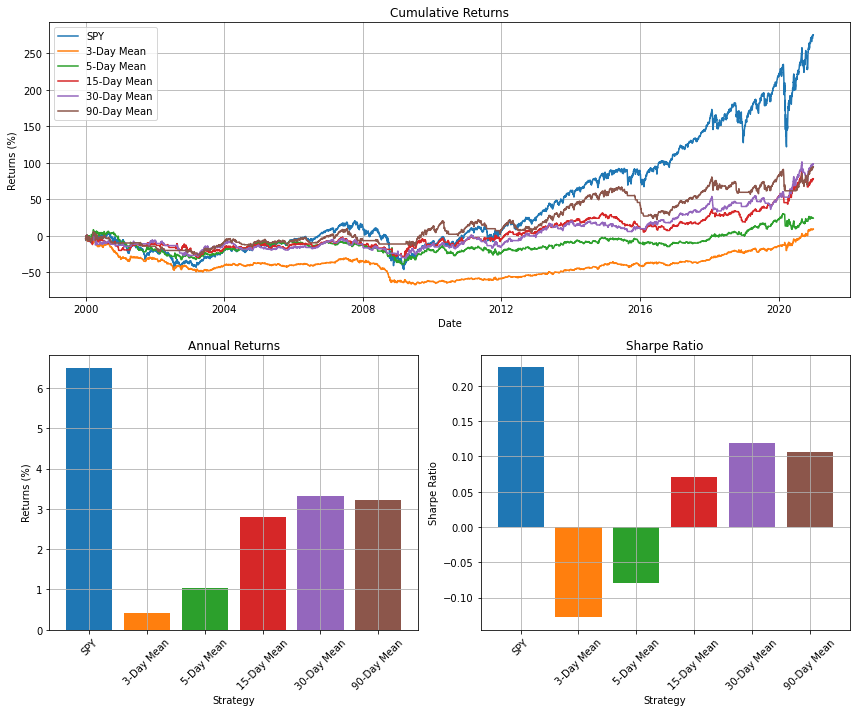

In [6]:
import matplotlib.gridspec as gridspec
periods = [3, 5, 15, 30, 90]
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 4)
ax0 = fig.add_subplot(gs[:2, :4])
ax1 = fig.add_subplot(gs[2:, :2])
ax2 = fig.add_subplot(gs[2:, 2:])
ax0.plot((np.exp(returns.cumsum()) - 1) * 100, label=ticker, linestyle='-')
perf_dict = {'tot_ret': {'buy_and_hold': (np.exp(returns.sum()) - 1)}}
perf_dict['ann_ret'] = {'buy_and_hold': b_ann}
perf_dict['sharpe'] = {'buy_and_hold': b_sharpe}
for p in periods:
    log_perf = TSMStrategy(returns, period=p, shorts=False)
    perf = np.exp(log_perf.cumsum())
    perf_dict['tot_ret'][p] = (perf[-1] - 1)
    ann = (perf[-1] ** (1/years) - 1)
    perf_dict['ann_ret'][p] = ann
    vol = log_perf.std() * np.sqrt(252)
    perf_dict['sharpe'][p] = (ann - rfr) / vol
    ax0.plot((perf - 1) * 100, label=f'{p}-Day Mean')
    
ax0.set_ylabel('Returns (%)')
ax0.set_xlabel('Date')
ax0.set_title('Cumulative Returns')
ax0.grid()
ax0.legend()
_ = [ax1.bar(i, v * 100) for i, v in enumerate(perf_dict['ann_ret'].values())]
ax1.set_xticks([i for i, k in enumerate(perf_dict['ann_ret'])])
ax1.set_xticklabels([f'{k}-Day Mean' 
    if type(k) is int else ticker for 
    k in perf_dict['ann_ret'].keys()],
    rotation=45)
ax1.grid()
ax1.set_ylabel('Returns (%)')
ax1.set_xlabel('Strategy')
ax1.set_title('Annual Returns')
_ = [ax2.bar(i, v) for i, v in enumerate(perf_dict['sharpe'].values())]
ax2.set_xticks([i for i, k in enumerate(perf_dict['sharpe'])])
ax2.set_xticklabels([f'{k}-Day Mean' 
    if type(k) is int else ticker for 
    k in perf_dict['sharpe'].keys()],
    rotation=45)
ax2.grid()
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Strategy')
ax2.set_title('Sharpe Ratio')
plt.tight_layout()
plt.show()

## Relative Momentum Trading Strategy
參考[How to Create a Relative Momentum Trading Strategy in Python](https://www.the905guy.ca/article/how-to-create-a-relative-momentum-trading-strategy-in-python?fbclid=IwAR1fX2udgpI2SJ9omlEyK81nQJgmFMQVU4XfRzbbG7hFCrPVgYcLP4YARXc)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import fix_yahoo_finance as yf

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [4]:
my_df = pd.read_csv('mf_testing_data.csv')
my_df

,Date,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
0,2013-12-31,67.66,48.94,11.69,22.43,32.65,164.98,32.91,68.28,68.38,83.12
1,2014-01-02,66.71,49.09,11.70,22.00,32.72,164.63,32.69,67.55,68.57,81.93
2,2014-01-03,65.24,50.15,11.75,21.99,31.62,165.80,32.47,67.47,68.35,81.73
3,2014-01-06,65.60,50.54,11.81,21.81,32.28,166.94,31.78,67.63,67.96,81.86
4,2014-01-07,65.13,50.89,11.65,21.83,32.12,165.93,32.03,68.29,68.17,83.01
...,...,...,...,...,...,...,...,...,...,...,...
1254,2018-12-24,145.64,48.60,7.25,6.65,32.05,155.72,93.38,86.07,84.91,64.06
1255,2018-12-26,155.90,50.75,7.46,7.10,33.19,162.27,99.76,88.76,89.45,67.12
1256,2018-12-27,154.89,51.08,7.46,6.98,33.63,164.74,100.38,90.66,90.62,67.41
1257,2018-12-28,154.97,51.14,7.42,7.21,33.59,162.37,99.59,89.83,91.15,66.66


In [26]:
my_df['Date'] = pd.to_datetime(my_df['Date'], dayfirst=False)
my_df.set_index('Date', inplace=True)
my_df

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2013-12-31,67.66,48.94,11.69,22.43,32.65,164.98,32.91,68.28,68.38,83.12
2014-01-02,66.71,49.09,11.70,22.00,32.72,164.63,32.69,67.55,68.57,81.93
2014-01-03,65.24,50.15,11.75,21.99,31.62,165.80,32.47,67.47,68.35,81.73
2014-01-06,65.60,50.54,11.81,21.81,32.28,166.94,31.78,67.63,67.96,81.86
2014-01-07,65.13,50.89,11.65,21.83,32.12,165.93,32.03,68.29,68.17,83.01
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,145.64,48.60,7.25,6.65,32.05,155.72,93.38,86.07,84.91,64.06
2018-12-26,155.90,50.75,7.46,7.10,33.19,162.27,99.76,88.76,89.45,67.12
2018-12-27,154.89,51.08,7.46,6.98,33.63,164.74,100.38,90.66,90.62,67.41


In [5]:
price_df = yf.download(['AAPL','C','F','GE','GM','GS','MSFT','PG','WMT','XOM'], start="2014-01-01", end="2019-01-01")
price_df

[*********************100%***********************]  10 of 10 completed


Adj Close                                               \
                 AAPL          C          F          GE         GM   
Date                                                                 
2013-12-31  17.743860  44.636387  11.243423  180.070923  31.588171   
2014-01-02  17.494314  44.773453  11.250708  176.666122  31.650002   
2014-01-03  17.110044  45.741386  11.301715  176.537598  30.583405   
2014-01-06  17.203348  46.092590  11.352723  175.124298  31.224911   
2014-01-07  17.080317  46.409527  11.206990  175.317001  31.070330   
...               ...        ...        ...         ...        ...   
2018-12-24  35.589466  44.326981   6.964272   52.537075  30.689299   
2018-12-26  38.095730  46.288666   7.165075   56.105339  31.779594   
2018-12-27  37.848503  46.585629   7.165075   55.194294  32.196747   
2018-12-28  37.867893  46.639614   7.128565   57.016384  32.158821   
2018-12-31  38.233894  46.846581   6.982526   57.471920  31.713224   

                                                                    ...  \
                    GS       MSFT         PG        WMT        XOM  ...   
Date                                                                ...   
2013-12-31  154.832062  32.012253  63.825523  64.992668  69.994431  ...   
2014-01-02  154.508881  31.798319  63.143436  65.174377  68.991508  ...   
2014-01-03  155.609467  31.584389  63.072876  64.959641  68.825539  ...   
2014-01-06  156.675064  30.916933  63.221809  64.596237  68.929276  ...   
2014-01-07  155.731781  31.156536  63.833347  64.794449  69.904488  ...   
...                ...        ...        ...        ...        ...  ...   
2018-12-24  146.146851  90.835320  80.454704  81.126419  53.940750  ...   
2018-12-26  152.297424  97.040253  82.968903  85.465393  56.517982  ...   
2018-12-27  154.615631  97.638550  84.746346  86.580864  56.765003  ...   
2018-12-28  152.390900  96.876205  83.972740  87.091339  56.130978  ...   
2018-12-31  156.148575  98.014908  84.654251  88.055534  56.147446  ...   

               Volume                                                   \
                 AAPL         C         F        GE        GM       GS   
Date                                                                     
2013-12-31  223084400  10706800  27829000   3939871  11100900  1663900   
2014-01-02  234684800  16479700  31528500   5388981  14763300  1982100   
2014-01-03  392467600  26884900  46122300   3584204  41426900  2147400   
2014-01-06  412610800  28503100  42657600   3816358  25063500  2954000   
2014-01-07  317209200  28840400  54476300   3214640  14156900  2734700   
...               ...       ...       ...       ...       ...      ...   
2018-12-24  148676800  21970800  38709500   9101352   9110200  3783500   
2018-12-26  234330000  32005600  58810000  16879018  12490400  7054700   
2018-12-27  212468400  28573400  49813000  15571218  13653000  4973000   
2018-12-28  169165600  23176900  47331700  15817204   8678000  4110500   
2018-12-31  140014000  19317500  57816000  14086995   8455500  4550000   

                                                    
                MSFT        PG       WMT       XOM  
Date                                                
2013-12-31  17503500   5765300   3859100   8509600  
2014-01-02  30632200   6981700   6878000  11028100  
2014-01-03  31134800   6925600   4957400   9295600  
2014-01-06  43603700   7208200   7280200  11848500  
2014-01-07  35802800   7158200   5012300  11187000  
...              ...       ...       ...       ...  
2018-12-24  43935200   7396300   6110300  14262800  
2018-12-26  51634800   8630900  10028300  24887700  
2018-12-27  49498500  11360100   9881500  22077000  
2018-12-28  38196300   9611800   9874000  19710600  
2018-12-31  33173800   7239500   7005800  15807000  

[1259 rows x 60 columns]

In [6]:
my_df = price_df['Close']
my_df

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2013-12-31,20.036428,52.110001,15.43,215.615387,40.869999,177.259995,37.410000,81.410004,78.690002,101.199997
2014-01-02,19.754642,52.270000,15.44,211.538467,40.950001,176.889999,37.160000,80.540001,78.910004,99.750000
2014-01-03,19.320715,53.400002,15.51,211.384613,39.570000,178.149994,36.910000,80.449997,78.650002,99.510002
2014-01-06,19.426071,53.810001,15.58,209.692307,40.400002,179.369995,36.130001,80.639999,78.209999,99.660004
2014-01-07,19.287144,54.180000,15.38,209.923080,40.200001,178.289993,36.410000,81.419998,78.449997,101.070000
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,36.707500,49.259998,7.63,53.230770,32.369999,156.350006,94.129997,87.360001,85.820000,65.510002
2018-12-26,39.292500,51.439999,7.85,56.846153,33.520000,162.929993,100.559998,90.089996,90.410004,68.639999
2018-12-27,39.037498,51.770000,7.85,55.923077,33.959999,165.410004,101.180000,92.019997,91.589996,68.940002


In [7]:
mom_period = 10 #126
rebal_freq = 1 #22

In [8]:
my_df_pct = my_df.pct_change(mom_period)
my_df_pct

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.134257,-0.136850,-0.104460,-0.001443,-0.059558,-0.125706,-0.125105,-0.060948,-0.086438,-0.144108
2018-12-26,-0.067959,-0.085023,-0.080796,0.093195,-0.033727,-0.078450,-0.073948,-0.040677,-0.036654,-0.104851
2018-12-27,-0.076582,-0.075205,-0.091435,0.083458,-0.048206,-0.063894,-0.072424,-0.021376,-0.016325,-0.093133


In [9]:
my_df_pct['AAPL'].iloc[10]

-0.006523838159084305

In [10]:
my_df_pct = my_df_pct[mom_period:]
my_df_pct

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2014-01-15,-0.006524,0.055268,0.082307,-0.024616,-0.036457,0.008406,-0.017375,-0.007616,-0.013089,-0.023913
2014-01-16,0.002025,0.006313,0.083549,-0.010909,-0.047619,-0.009724,-0.007266,0.000248,-0.027246,-0.008120
2014-01-17,-0.000573,-0.021161,0.065119,-0.032751,-0.024514,-0.010497,-0.014359,-0.007085,-0.031278,-0.003517
2014-01-21,0.009450,-0.036425,0.053273,-0.035583,-0.050990,-0.034398,0.001107,-0.005704,-0.030303,-0.011640
2014-01-22,0.021239,-0.042082,0.076073,-0.047636,-0.034826,-0.025857,-0.013183,-0.026898,-0.039516,-0.031562
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.134257,-0.136850,-0.104460,-0.001443,-0.059558,-0.125706,-0.125105,-0.060948,-0.086438,-0.144108
2018-12-26,-0.067959,-0.085023,-0.080796,0.093195,-0.033727,-0.078450,-0.073948,-0.040677,-0.036654,-0.104851
2018-12-27,-0.076582,-0.075205,-0.091435,0.083458,-0.048206,-0.063894,-0.072424,-0.021376,-0.016325,-0.093133


In [11]:
my_df_ranks = pd.DataFrame(columns=my_df_pct.columns, index=my_df_pct.index)
my_df_ranks

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2014-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
def my_modulo(a, b):

    while a >= b:
        a -= b

    return a

In [13]:
for i in range(len(my_df_pct)):

    if i % rebal_freq == 0:

        my_df_ranks.iloc[i] = my_df_pct.iloc[i].rank(axis=0, ascending=False)

In [14]:
my_df_ranks = my_df_ranks.shift(periods=1, axis=0)

In [15]:
my_df_ranks.ffill(inplace=True)
my_df_ranks

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2014-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-16,4.0,2.0,1.0,9.0,10.0,3.0,7.0,5.0,6.0,8.0
2014-01-17,3.0,2.0,1.0,8.0,10.0,7.0,5.0,4.0,9.0,6.0
2014-01-21,2.0,7.0,1.0,10.0,8.0,5.0,6.0,4.0,9.0,3.0
2014-01-22,2.0,9.0,1.0,8.0,10.0,7.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,7.0,10.0,6.0,1.0,3.0,8.0,4.0,2.0,5.0,9.0
2018-12-26,8.0,9.0,5.0,1.0,2.0,7.0,6.0,3.0,4.0,10.0
2018-12-27,5.0,9.0,8.0,1.0,2.0,7.0,6.0,4.0,3.0,10.0


In [16]:
num_long = 5
num_short = 0 #3
num_stocks = my_df_ranks.shape[1] - num_short + 1

In [17]:
for col in my_df_ranks.columns:

    # if a stock has a rank in the top num_long values, we go long
    my_df_ranks.loc[my_df_ranks[col] <= num_long, col] = 1

    # if a stock has a rank in the bottom num_short values, we go short
    my_df_ranks.loc[my_df_ranks[col] >= num_stocks, col] = -1

    # if a stock doesn't have a ranking in top or bottom n values, we have no position
    my_df_ranks.loc[(my_df_ranks[col] < num_stocks) & (my_df_ranks[col] > num_long), col] = None
    
my_df_ranks 

,AAPL,C,F,GE,GM,GS,MSFT,PG,WMT,XOM
Date,,,,,,,,,,
2014-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-16,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
2014-01-17,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2014-01-21,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0
2014-01-22,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN
2018-12-26,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN
2018-12-27,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN


In [18]:
mult_df = (my_df.pct_change()) * my_df_ranks

In [19]:
mult_df['Total Return'] = (mult_df.sum(axis=1, skipna=True)) / (num_long + num_short)
mult_df = mult_df[mom_period:]

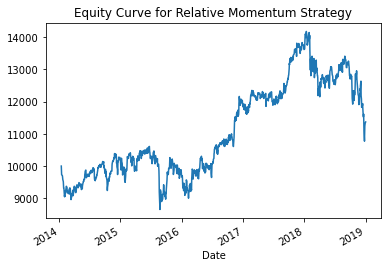

In [20]:
# Take the Daily Return of the strategy and computer the growth of strategy in $
mult_df['Portfolio Value'] = ((mult_df['Total Return'] + 1).cumprod()) * 10000

mult_df['Portfolio Value'].plot()
plt.title('Equity Curve for Relative Momentum Strategy')
plt.show()

## Mean Reversion
參考[A Simple Mean Reversion System in Simple Python Code](https://gist.github.com/AnthonyFJGarner/ccd23f0e9d46214612f59c7b92a82149?fbclid=IwAR009-5uFVZAMK2klvNQWrCA8Le7FX9sULY8YA1nLz0KMkb0_kzZRi7oaJs)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# %matplotlib notebook
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import fix_yahoo_finance as yf
#because the is_list_like is moved to pandas.api.types
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn

In [22]:
# ts = TimeSeries(key='insert own key', output_format='pandas')
# data, meta_data = ts.get_daily_adjusted(symbol='SPY', outputsize='full')
data = yf.download("SPY", start="1970-01-01", end="2018-12-08")

[*********************100%***********************]  1 of 1 completed


In [23]:
data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)
# data.to_csv('../data/Stocks/spy.csv')
data.head()

,Open,High,Low,Close,Adj_Close,Volume,Adj_Open
Date,,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547979,1003200,25.566150
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729683,480500,25.566147
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784210,201300,25.711527
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056749,529400,25.820531
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165779,531500,26.147608


In [24]:
pricing = data.reset_index()[['Date','Adj_Open', 'Adj_Close']]
pricing

,Date,Adj_Open,Adj_Close
0,1993-01-29,25.566150,25.547979
1,1993-02-01,25.566147,25.729683
2,1993-02-02,25.711527,25.784210
3,1993-02-03,25.820531,26.056749
4,1993-02-04,26.147608,26.165779
...,...,...,...
6508,2018-11-30,258.012258,259.746094
6509,2018-12-03,264.108923,263.185455
6510,2018-12-04,262.309079,254.657578
6511,2018-12-06,250.577396,254.271210


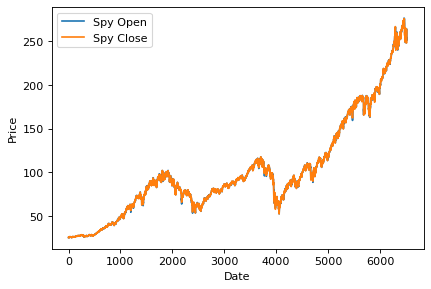

In [25]:
# pricing = pd.read_csv(
#     '../data/Stocks/spy.csv',
#     header=0,
#     parse_dates=["Date"],
#     #index_col=0,
#     usecols=['Date','Adj_Open', 'Adj_Close'])

figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pricing.Adj_Open, label='Spy Open')
plt.plot(pricing.Adj_Close, label='Spy Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [26]:
pricing.head()

,Date,Adj_Open,Adj_Close
0,1993-01-29,25.566150,25.547979
1,1993-02-01,25.566147,25.729683
2,1993-02-02,25.711527,25.784210
3,1993-02-03,25.820531,26.056749
4,1993-02-04,26.147608,26.165779


In [27]:
stock=pricing.copy()
stock.Adj_Close=stock.Adj_Close.shift(1)

stock.tail()

,Date,Adj_Open,Adj_Close
6508,2018-11-30,258.012258,258.172424
6509,2018-12-03,264.108923,259.746094
6510,2018-12-04,262.309079,263.185455
6511,2018-12-06,250.577396,254.657578
6512,2018-12-07,253.913161,254.271210


In [28]:
stock_1=stock.iloc[0:2170].copy()
stock_2=stock.iloc[2170:4342].copy().reset_index(drop=True)
stock_3=stock.iloc[4342:6513].copy().reset_index(drop=True) 
stock_2.head()

,Date,Adj_Open,Adj_Close
0,2001-09-04,76.802688,77.005066
1,2001-09-05,76.701492,76.512611
2,2001-09-06,75.993157,76.701492
3,2001-09-07,74.218989,74.724915
4,2001-09-10,72.653961,73.342018


In [29]:
def trade(stock, length):

    temp_dict = {}
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0

    # Compute rolling means and rolling standard deviation
    #sma and lma are filters to prevent taking long or short positions against the longer term trend
    rolling_window = stock.Adj_Close.rolling(window=length)
    mu = rolling_window.mean()
    sma = stock.Adj_Close.rolling(window=length*1).mean()
    lma = stock.Adj_Close.rolling(window=length * 10).mean()
    std = rolling_window.std()

    #If you don't use a maximum position size the positions will keep on pyramidding.
    #Set max_position to a high number (1000?) to disable this parameter
    #Need to beware of unintended leverage
    max_position = 1
    percent_per_trade = 1.0

    #Slippage and commission adjustment  - simply reduces equity by a percentage guess
    # a setting of 1 means no slippage, a setting of 0.999 gives 0.1% slippage
    slippage_adj = 1

    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock.Adj_Close - mu) / std

    # Simulate trading
    # Start with your chosen starting capital and no positions
    money = 1000.00
    position_count = 0

    for i, row in enumerate(stock.itertuples(), 0):

        #set up position size so that each position is a fixed position of your account equity
        equity = money + (stock.Adj_Close[i] * position_count)
        if equity > 0:
            fixed_frac = (equity * percent_per_trade) / stock.Adj_Close[i]
        else:
            fixed_frac = 0
        fixed_frac = int(round(fixed_frac))

        #exit all positions if zscore flips from positive to negative or vice versa without going through
        #the neutral zone
        if i > 0:
            if (zscores[i - 1] > 0.5
                    and zscores[i] < -0.5) or (zscores[i - 1] < -0.5
                                               and zscores[i] > 0.5):

                if position_count > 0:
                    money += position_count * stock.Adj_Close[i] * slippage_adj
                elif position_count < 0:
                    money += position_count * stock.Adj_Close[i] * (
                        1 / slippage_adj)
                position_count = 0

        # Sell short if the z-score is > 1 and if the longer term trend is negative
        if (zscores[i] > 1) & (position_count > max_position * -1) & (sma[i] <
                                                                      lma[i]):

            position_count -= fixed_frac
            money += fixed_frac * stock.Adj_Close[i] * slippage_adj

        # Buy long if the z-score is < 1 and the longer term trend is positive
        elif zscores[i] < -1 and position_count < max_position and sma[i] > lma[i]:

            position_count += fixed_frac
            money -= fixed_frac * stock.Adj_Close[i] * (1 / slippage_adj)

        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            #money += position_count * stock.Adj_Close[i]
            if position_count > 0:
                money += position_count * stock.Adj_Close[i] * slippage_adj
            elif position_count < 0:
                money += position_count * stock.Adj_Close[i] * (
                    1 / slippage_adj)
            position_count = 0

        #fill dictionary with the trading results.
        temp_dict[stock.Date[i]] = [
            stock.Adj_Open[i], stock.Adj_Close[i], mu[i], std[i], zscores[i],
            money, position_count, fixed_frac, sma[i], lma[i]
        ]
    #create a dataframe to return for use in calculating and charting the trading results
    pr = pd.DataFrame(data=temp_dict).T
    pr.index.name = 'Date'
    pr.index = pd.to_datetime(pr.index)
    pr.columns = [
        'Open', 'Close', 'mu', 'std', 'zscores', 'money', 'position_count',
        'fixed_frac', 'sma', 'lma'
    ]
    pr['equity'] = pr.money + (pr.Close * pr.position_count)
    #
    return pr

In [30]:
moving_average=10
profit = trade(stock, moving_average)
# profit.to_csv('../data/mean_reversion_profit.csv')

In [31]:
profit.tail()

,Open,Close,mu,std,zscores,money,position_count,fixed_frac,sma,lma,equity
Date,,,,,,,,,,,
2018-11-30,258.012258,258.172424,253.734135,4.084263,1.086680,15941.824448,-31.0,31.0,253.734135,264.414363,7938.479294
2018-12-03,264.108923,259.746094,253.981972,4.386519,1.314054,15941.824448,-31.0,30.0,253.981972,264.414718,7889.695541
2018-12-04,262.309079,263.185455,254.506837,5.158408,1.682422,15941.824448,-31.0,30.0,254.506837,264.425922,7783.075333
2018-12-06,250.577396,254.657578,254.615204,5.148004,0.008231,8047.439545,0.0,32.0,254.615204,264.349784,8047.439545
2018-12-07,253.913161,254.271210,255.154198,4.747546,-0.185988,8047.439545,0.0,32.0,255.154198,264.272126,8047.439545


In [37]:
profit

,Open,Close,mu,std,zscores,money,position_count,fixed_frac,sma,lma,equity
Date,,,,,,,,,,,
1993-01-29,25.566150,NaN,NaN,NaN,NaN,1000.000000,0.0,0.0,NaN,NaN,NaN
1993-02-01,25.566147,25.547979,NaN,NaN,NaN,1000.000000,0.0,39.0,NaN,NaN,1000.000000
1993-02-02,25.711527,25.729683,NaN,NaN,NaN,1000.000000,0.0,39.0,NaN,NaN,1000.000000
1993-02-03,25.820531,25.784210,NaN,NaN,NaN,1000.000000,0.0,39.0,NaN,NaN,1000.000000
1993-02-04,26.147608,26.056749,NaN,NaN,NaN,1000.000000,0.0,38.0,NaN,NaN,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...
2018-11-30,258.012258,258.172424,253.734135,4.084263,1.086680,15941.824448,-31.0,31.0,253.734135,264.414363,7938.479294
2018-12-03,264.108923,259.746094,253.981972,4.386519,1.314054,15941.824448,-31.0,30.0,253.981972,264.414718,7889.695541
2018-12-04,262.309079,263.185455,254.506837,5.158408,1.682422,15941.824448,-31.0,30.0,254.506837,264.425922,7783.075333


In [45]:
series=profit[['equity']].copy()

In [46]:
# series['equity']*=0.5
series

,equity
Date,
1993-01-29,NaN
1993-02-01,1000.000000
1993-02-02,1000.000000
1993-02-03,1000.000000
1993-02-04,1000.000000
...,...
2018-11-30,7938.479294
2018-12-03,7889.695541
2018-12-04,7783.075333


In [33]:
stats = series.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                1993-02-01
End                  2018-12-07
Risk-free rate       0.00%

Total Return         704.74%
Daily Sharpe         0.85
Daily Sortino        1.33
CAGR                 8.40%
Max Drawdown         -14.56%
Calmar Ratio         0.58

MTD                  1.37%
3m                   -0.79%
6m                   -1.34%
YTD                  -4.56%
1Y                   -4.56%
3Y (ann.)            1.71%
5Y (ann.)            3.63%
10Y (ann.)           7.92%
Since Incep. (ann.)  8.40%

Daily Sharpe         0.85
Daily Sortino        1.33
Daily Mean (ann.)    8.58%
Daily Vol (ann.)     10.11%
Daily Skew           0.41
Daily Kurt           24.90
Best Day             8.86%
Worst Day            -7.18%

Monthly Sharpe       1.06
Monthly Sortino      1.96
Monthly Mean (ann.)  8.41%
Monthly Vol (ann.)   7.93%
Monthly Skew         0.29
Monthly Kurt         7.32
Best Month           15.69%
Worst Month          -9.61%

Yearl

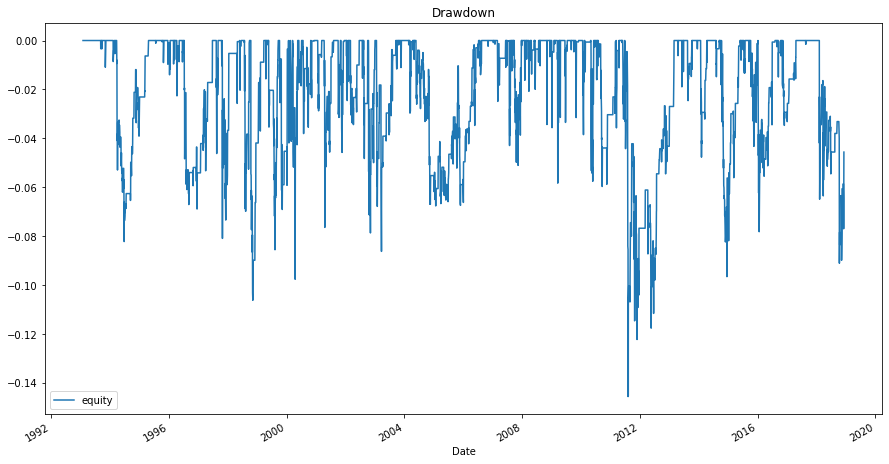

In [34]:
prices =series
ax = stats.prices.to_drawdown_series().plot(figsize=(15, 8),title='Drawdown')

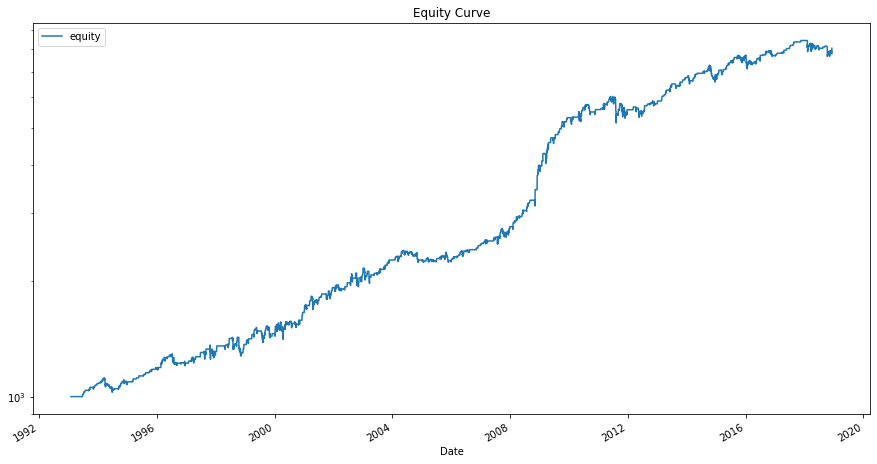

In [35]:
ax = prices.plot(logy=True,figsize=(15, 8),title='Equity Curve')

In [36]:
plt.show()

### Mean Reversion - Portfolio

In [47]:
def get_1_stock_simulate(stock_name,start_date,end_date,moving_average):
    data = yf.download(stock_name, start=start_date, end=end_date)
    data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
    data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)
    pricing = data.reset_index()[['Date','Adj_Open', 'Adj_Close']]
    stock=pricing.copy()
    stock.Adj_Close=stock.Adj_Close.shift(1)
    profit = trade(stock, moving_average)
    return profit

In [48]:
comb = ['ITOT', 'VEU', 'VNQ', 'AGG']#['ITOT VEU VNQ AGG','0.36 0.18 0.06 0.4']
weights = [0.36,0.18,0.06,0.4]
moving_average=10
start_date = '2016-01-01'
end_date = '2021-01-01'

In [49]:
all_simulate = []
for stock_name in comb:
    profit = get_1_stock_simulate(stock_name,start_date,end_date,moving_average)
    all_simulate.append(profit)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [50]:
if weights is None:
    weights = [1/len(comb)]*len(comb)
    
all_series = []
for i in range(len(all_simulate)):
    series = profit[['equity']].copy()
    series *= weights[i]
    all_series.append(series)

In [54]:
final_money = pd.concat(all_series,axis=1)
final_money.columns = comb
final_money

,ITOT,VEU,VNQ,AGG
Date,,,,
2015-12-31,NaN,NaN,NaN,NaN
2016-01-04,360.000000,180.000000,60.000000,400.000000
2016-01-05,360.000000,180.000000,60.000000,400.000000
2016-01-06,360.000000,180.000000,60.000000,400.000000
2016-01-07,360.000000,180.000000,60.000000,400.000000
...,...,...,...,...
2020-12-24,374.019604,187.009802,62.336601,415.577338
2020-12-28,374.019604,187.009802,62.336601,415.577338
2020-12-29,374.019604,187.009802,62.336601,415.577338


In [62]:
final_money_sum = final_money.T.sum()
final_money_sum = pd.DataFrame(final_money_sum)
final_money_sum.columns = ['equity']
final_money_sum

,equity
Date,
2015-12-31,0.000000
2016-01-04,1000.000000
2016-01-05,1000.000000
2016-01-06,1000.000000
2016-01-07,1000.000000
...,...
2020-12-24,1038.943344
2020-12-28,1038.943344
2020-12-29,1038.943344


In [70]:
final_money_sum = final_money_sum[final_money_sum['equity']!=0]
final_money_sum

,equity
Date,
2016-01-04,1000.000000
2016-01-05,1000.000000
2016-01-06,1000.000000
2016-01-07,1000.000000
2016-01-08,1000.000000
...,...
2020-12-24,1038.943344
2020-12-28,1038.943344
2020-12-29,1038.943344


In [71]:
stats = final_money_sum.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                2016-01-04
End                  2020-12-31
Risk-free rate       0.00%

Total Return         3.89%
Daily Sharpe         0.24
Daily Sortino        0.30
CAGR                 0.77%
Max Drawdown         -7.42%
Calmar Ratio         0.10

MTD                  0.58%
3m                   1.40%
6m                   1.52%
YTD                  0.51%
1Y                   0.51%
3Y (ann.)            0.56%
5Y (ann.)            0.77%
10Y (ann.)           -
Since Incep. (ann.)  0.77%

Daily Sharpe         0.24
Daily Sortino        0.30
Daily Mean (ann.)    0.83%
Daily Vol (ann.)     3.44%
Daily Skew           -7.15
Daily Kurt           176.22
Best Day             2.27%
Worst Day            -3.84%

Monthly Sharpe       0.46
Monthly Sortino      0.60
Monthly Mean (ann.)  0.79%
Monthly Vol (ann.)   1.72%
Monthly Skew         -2.65
Monthly Kurt         12.87
Best Month           0.86%
Worst Month          -2.54%

Yearly Sharpe 

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [ ]:
series=profit[['equity']].copy()
stats = series.calc_stats()
stats.display()

In [38]:
[1/4]*4

[0.25, 0.25, 0.25, 0.25]